# Data Preparation

## Install Neccessary Modules

In [1]:
# Clone TensorFlow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

Cloning into 'models'...
remote: Enumerating objects: 3658, done.
remote: Counting objects: 100% (3658/3658), done.
remote: Compressing objects: 100% (3060/3060), done.
remote: Total 3658 (delta 968), reused 1502 (delta 546), pack-reused 0
Receiving objects: 100% (3658/3658), 47.39 MiB | 26.96 MiB/s, done.
Resolving deltas: 100% (968/968), done.


In [2]:
# install the Tensorflow Object Detection API
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 101.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.4/662.4 KB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB

## Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [4]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

# import module for visualization. use the alias `viz_utils`
from object_detection.utils  import visualization_utils as viz_utils
from object_detection.utils import colab_utils

## Utility functions

In [5]:
def resize_image(image_path):
  """Function to resize an image.

  Args:
  image_path: The image path.

  Returns:
  A resized image
  """
    
  image = keras.utils.load_img(image_path)
  w, h = image.size

  if h > w:
    image = image.resize((400, 450)) # width, height convention for image
  else:
    image = image.resize((400, 250)) # width, height convention for image
  
  return image

In [6]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Function to visualize detections.

    Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape for the boxes
    classes: The numpy array of shape for the classes
    scores: The numpy array of shape for the scores
    category_index: a dict of category dictionaries .
    figsize: size for the figure.
    image_name: The image file.
    """
    
    image_np_with_annotations = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    
    else:
        plt.imshow(image_np_with_annotations)

## Image Annotation with Bounding Boxes

In [7]:
# Resize images and store the image arrays 
path = "/content/drive/MyDrive/AI/Project/images" 
image_list = os.listdir(path)
images = []

for i in range(len(image_list)):
  image = resize_image(f"{path}/{image_list[i]}")
  images.append(np.array(image))

In [8]:
images[0].shape

(450, 400, 3)

In [9]:
gt_boxes = [] # Store ground truth values

# Annotate Images
colab_utils.annotate(images, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

## Create Annotation Database

In [ ]:
import copy

# Copy data to avoid mutating the data structure
gt_bx = copy.deepcopy(gt_boxes)

In [ ]:
# Remove unwanted annotation
annots = [np.delete(ann, 0, 0) if len(ann) > 1 else ann for ann in gt_bx]

In [ ]:
# Map image name to image array, and annot
ann_db = zip(image_list, images, annots)

In [ ]:
# Sort by image name
sorted_ann_db = sorted(ann_db)

In [ ]:
# Create dictionary of all annotations
annots_db = dict()

for i in range(len(sorted_ann_db)):
  annots_db[f"player_{i+1}"] = {
      "img": sorted_ann_db[i][0],
      "img_np_arr": sorted_ann_db[i][1],
      "bbox": sorted_ann_db[i][2]
  }

In [ ]:
# Get images' arrays and ground truth bounding boxes 
np_imgs = []
gtbxs = []
for arr in annots_db:
  np_imgs.append(annots_db[arr]["img_np_arr"])
  gtbxs.append(annots_db[arr]["bbox"])

## Visualize Players Images as Sanity Check

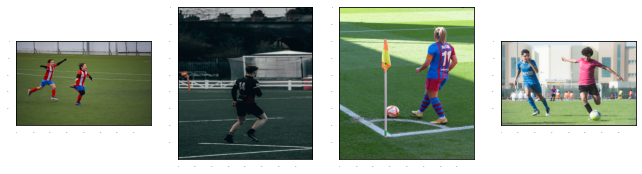

In [ ]:
%matplotlib inline

# configure plot settings via rcParams
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

# plot images
for idx, image in enumerate(np_imgs[:4]):
    plt.subplot(1, 5, idx+1)
    plt.imshow(image)

plt.show()

In [ ]:
# Assign the player class ID
player_class_id = 1

# define a dictionary describing the playe class
category_index = {player_class_id: {
    "id": player_class_id,
    "name": "player"
}}

# Specify the number of classes that the model will predict
num_classes = 1

In [ ]:
print(category_index[player_class_id])

{'id': 1, 'name': 'player'}


In [ ]:
# np_imgs[0]
np_imgs[0].dtype

dtype('uint8')

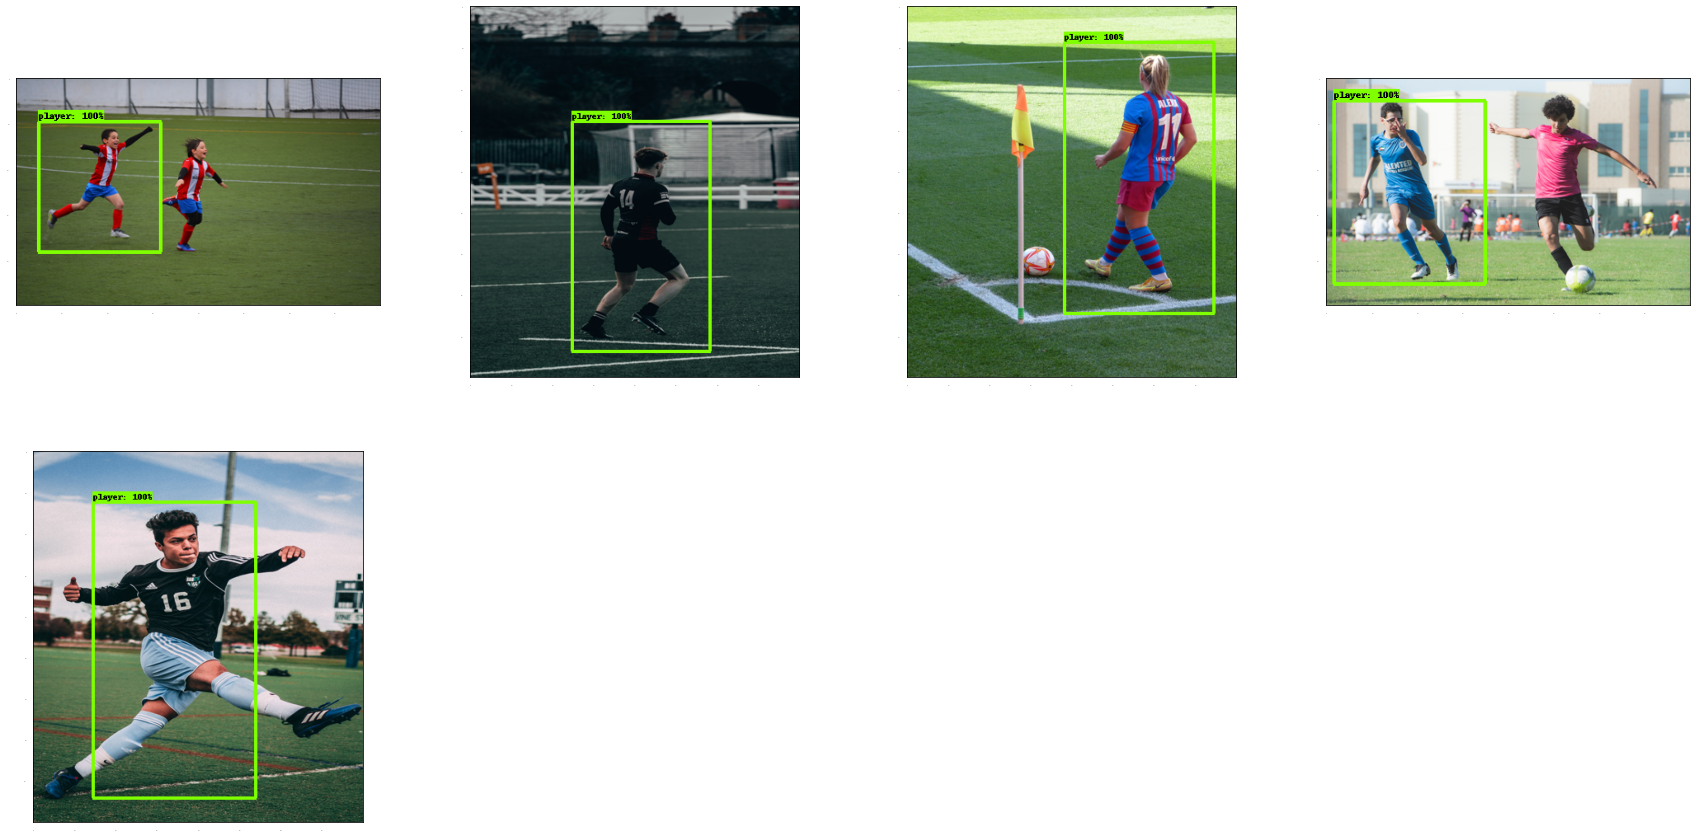

In [ ]:
# Give boxes 100%
dummy_scores = np.array([1.0], dtype=np.float32)

# define the figure size
plt.figure(figsize=(30, 15))

# Draw ground truth boxes
for idx in range(5): 
    plt.subplot(2, 4, idx+1)
    plot_detections(
      np_imgs[idx],
      gtbxs[idx],
      np.ones(shape=[gtbxs[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
   

plt.show()

## Prepare Data

In [ ]:
image_size = 224 # resize images

imgs, targets = [], [] # Store numpy array of images, and bounding boxes of each image

for i in range(len(gtbxs)):
  x, y = gtbxs[i][0][0], gtbxs[i][0][1]
  w, h = gtbxs[i][0][2], gtbxs[i][0][3]
  
  img = keras.utils.array_to_img(np_imgs[i])

  if i < int(len(gtbxs) * 0.8):
    img = img.resize((224, 224))

  imgs.append(keras.utils.img_to_array(img))
  targets.append(
      (x, y, w, h)
  )

In [ ]:
# Convert the list to numpy array, split the data to train and test set
(x_train), (y_train) = (
    np.asarray(imgs[: int(len(imgs) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(imgs[int(len(imgs) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)

<ipython-input-374-1d52e70c0a8a>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(imgs[int(len(imgs) * 0.8) :]),


### Save train and test data in drive

In [ ]:
drive_path = "/content/drive/MyDrive/AI/Project"

In [ ]:
# Make directory to save numpy files
try:
  print("Creating train folder...")
  os.mkdir(f"{drive_path}/train/")
  print("Creating test folder...")
  os.mkdir(f"{drive_path}/test/")
except FileExistsError:
  print("Directory already exist")
except:
  print("Unforseen circumstance")

Creating train folder...
Creating test folder...


In [ ]:
# Save train data as npy file
np.save(f'{drive_path}/train/x_train_images', x_train)
np.save(f'{drive_path}/train/y_train_annotations', y_train)

In [ ]:
# Save test data as npy file
np.save(f'{drive_path}/test/x_test_images', x_test)
np.save(f'{drive_path}/test/y_test_annotations', y_test)